In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import numpy as np
import pandas as pd
import math
import json
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
#from sklearn.externals import joblib
import scipy.sparse
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds
import warnings; warnings.simplefilter('ignore')
%matplotlib inline

In [2]:
columns=[ 'productId','userId', 'ratings']
df=pd.read_csv('D:\dataset\Video_Games.csv',names=columns)

In [3]:
df.head()

,productId,userId,ratings
0,439381673,A21ROB4YDOZA5P,1
1,439381673,A3TNZ2Q5E7HTHD,3
2,439381673,A1OKRM3QFEATQO,4
3,439381673,A2XO1JFCNEYV3T,1
4,439381673,A19WLPIRHD15TH,4


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048576 entries, 0 to 1048575
Data columns (total 3 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   productId  1048576 non-null  object
 1   userId     1048576 non-null  object
 2   ratings    1048576 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 24.0+ MB


In [5]:
rows,columns=df.shape
print('Number of rows: ',rows)
print('Number of columns: ',columns)

Number of rows:  1048576
Number of columns:  3


In [6]:
df.dtypes

productId    object
userId       object
ratings       int64
dtype: object

In [7]:
#take subset
df1=df.iloc[:50000,0:]
df1.head()

,productId,userId,ratings
0,439381673,A21ROB4YDOZA5P,1
1,439381673,A3TNZ2Q5E7HTHD,3
2,439381673,A1OKRM3QFEATQO,4
3,439381673,A2XO1JFCNEYV3T,1
4,439381673,A19WLPIRHD15TH,4


In [8]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   productId  50000 non-null  object
 1   userId     50000 non-null  object
 2   ratings    50000 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 1.1+ MB


In [9]:
df1['ratings'].describe()

count    50000.000000
mean         4.243960
std          1.265257
min          1.000000
25%          4.000000
50%          5.000000
75%          5.000000
max          5.000000
Name: ratings, dtype: float64

In [10]:
###Missing Values

In [11]:
print("missing values: \n",df.isnull().sum())

missing values: 
 productId    0
userId       0
ratings      0
dtype: int64


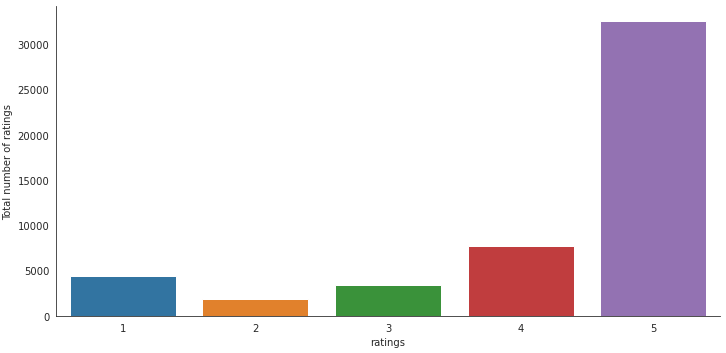

In [12]:
# Check the distribution of the rating
with sns.axes_style('white'):
    g = sns.factorplot("ratings", data=df1, aspect=2.0,kind='count')
    g.set_ylabels("Total number of ratings")

In [13]:
# Number of unique user id  in the data
print('Number of unique users in Raw data = ', df1['userId'].nunique())
# Number of unique product id  in the data
print('Number of unique product in Raw data = ', df1['productId'].nunique())

Number of unique users in Raw data =  37765
Number of unique product in Raw data =  1419


In [14]:
#Check the top 10 users based on ratings
most_rated=df1.groupby('userId').size().sort_values(ascending=False)[:10]
print('Top 10 users based on ratings: \n',most_rated)

Top 10 users based on ratings: 
 userId
A2582KMXLK2P06    99
A2TCG2HV1VJP6V    85
A2GBBDNZLYC4A9    69
A36UKFV79879MD    63
AWG2O9C42XW5G     56
A138826JMC0J3T    43
AJKWF4W7QD4NS     40
AQMWZIH22R6LE     39
ANAYSRE3LX8GZ     38
A119Q9NFGVOEJZ    37
dtype: int64


In [15]:
counts=df1.userId.value_counts()
df1_final=df1[df1.userId.isin(counts[counts>=25].index)]
print('Number of users who have rated 25 or more items =', len(df1_final))
print('Number of unique users in the final data = ', df1_final['userId'].nunique())
print('Number of unique products in the final data = ', df1_final['userId'].nunique())

Number of users who have rated 25 or more items = 908
Number of unique users in the final data =  22
Number of unique products in the final data =  22


In [16]:
#constructing the pivot table
final_ratings_matrix = df1_final.pivot_table(index = 'userId', columns ='productId', values = 'ratings').fillna(0)
final_ratings_matrix.head()

productId,804161380,9629971372,B000003SQQ,B000006OVE,B000006OVI,B000006OVJ,B000006OVK,B000006RGO,B000006RGR,B000007NJC,...,B00004SVXA,B00004SVXG,B00004SVXP,B00004SVXV,B00004SVY2,B00004SVYE,B00004SVYH,B00004SVYQ,B00004SVYT,B00004SVYU
userId,,,,,,,,,,,,,,,,,,,,,
A119Q9NFGVOEJZ,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0
A138826JMC0J3T,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,4.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0
A1JHJ48J9EZNMH,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A20DZX38KRBIT8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,3.0,5.0,0.0,0.0
A2582KMXLK2P06,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,1.0,...,0.0,4.0,0.0,0.0,1.0,4.0,0.0,0.0,4.0,0.0


In [17]:
print('Shape of final_ratings_matrix: ', final_ratings_matrix.shape)

Shape of final_ratings_matrix:  (22, 447)


In [18]:
#Calucating the density of the rating marix
given_num_of_ratings = np.count_nonzero(final_ratings_matrix)
print('given_num_of_ratings = ', given_num_of_ratings)
possible_num_of_ratings = final_ratings_matrix.shape[0] * final_ratings_matrix.shape[1]
print('possible_num_of_ratings = ', possible_num_of_ratings)
density = (given_num_of_ratings/possible_num_of_ratings)
density *= 100
print ('density: {:4.2f}%'.format(density))

given_num_of_ratings =  901
possible_num_of_ratings =  9834
density: 9.16%


In [19]:
#Split the data randomnly into train and test datasets into 70:30 ratio
train_data, test_data = train_test_split(df1_final, test_size = 0.3, random_state=0)
train_data.head()

,productId,userId,ratings
7188,B00000I1BJ,A2582KMXLK2P06,5
5575,B00000F1GM,A36UKFV79879MD,4
49931,B00004SVVJ,A2GBBDNZLYC4A9,5
26963,B00002ST6T,A319SKSB556033,4
40738,B000035Y38,A2TCG2HV1VJP6V,5


In [20]:
print('Shape of training data: ',train_data.shape)
print('Shape of testing data: ',test_data.shape)

Shape of training data:  (635, 3)
Shape of testing data:  (273, 3)


In [21]:
#Count of user_id for each unique product as recommendation score 
train_data_grouped = train_data.groupby('productId').agg({'userId': 'count'}).reset_index()
train_data_grouped.rename(columns = {'userId': 'score'},inplace=True)
train_data_grouped.head(10)

,productId,score
0,804161380,1
1,B000003SQQ,1
2,B000006OVE,1
3,B000006OVI,1
4,B000006OVJ,1
5,B000006OVK,1
6,B000006RGO,1
7,B000007NJC,2
8,B00000DMAM,1
9,B00000DMAQ,3


In [22]:
#Sort the products on recommendation score 
train_data_sort = train_data_grouped.sort_values(['score', 'productId'], ascending = [0,1]) 
      
#Generate a recommendation rank based upon score 
train_data_sort['rank'] = train_data_sort['score'].rank(ascending=0, method='first') 
          
#Get the top 5 recommendations 
popularity_recommendations = train_data_sort.head(5) 
popularity_recommendations

,productId,score,rank
286,B000035Y3N,8,1.0
166,B00002STXQ,7,2.0
199,B00002SVFV,7,3.0
287,B000035Y4T,7,4.0
51,B00000JRSB,6,5.0


In [23]:
# Use popularity based recommender model to make predictions
def recommend(user_id):     
    user_recommendations = popularity_recommendations 
          
    #Add user_id column for which the recommendations are being generated 
    user_recommendations['userId'] = user_id 
      
    #Bring user_id column to the front 
    cols = user_recommendations.columns.tolist() 
    cols = cols[-1:] + cols[:-1] 
    user_recommendations = user_recommendations[cols] 
          
    return user_recommendations

In [24]:
find_recom = [10,100,150]   # This list is user choice.
for i in find_recom:
    print("The list of recommendations for the userId: %d\n" %(i))
    print(recommend(i))    
    print("\n")

The list of recommendations for the userId: 10

     userId   productId  score  rank
286      10  B000035Y3N      8   1.0
166      10  B00002STXQ      7   2.0
199      10  B00002SVFV      7   3.0
287      10  B000035Y4T      7   4.0
51       10  B00000JRSB      6   5.0


The list of recommendations for the userId: 100

     userId   productId  score  rank
286     100  B000035Y3N      8   1.0
166     100  B00002STXQ      7   2.0
199     100  B00002SVFV      7   3.0
287     100  B000035Y4T      7   4.0
51      100  B00000JRSB      6   5.0


The list of recommendations for the userId: 150

     userId   productId  score  rank
286     150  B000035Y3N      8   1.0
166     150  B00002STXQ      7   2.0
199     150  B00002SVFV      7   3.0
287     150  B000035Y4T      7   4.0
51      150  B00000JRSB      6   5.0




In [25]:
df_CF = pd.concat([train_data, test_data]).reset_index()
df_CF.head()

,index,productId,userId,ratings
0,7188,B00000I1BJ,A2582KMXLK2P06,5
1,5575,B00000F1GM,A36UKFV79879MD,4
2,49931,B00004SVVJ,A2GBBDNZLYC4A9,5
3,26963,B00002ST6T,A319SKSB556033,4
4,40738,B000035Y38,A2TCG2HV1VJP6V,5


In [26]:
# Matrix with row per 'user' and column per 'item' 
pivot_df = df_CF.pivot_table(index = 'userId', columns ='productId', values = 'ratings').fillna(0)
pivot_df.head()

productId,804161380,9629971372,B000003SQQ,B000006OVE,B000006OVI,B000006OVJ,B000006OVK,B000006RGO,B000006RGR,B000007NJC,...,B00004SVXA,B00004SVXG,B00004SVXP,B00004SVXV,B00004SVY2,B00004SVYE,B00004SVYH,B00004SVYQ,B00004SVYT,B00004SVYU
userId,,,,,,,,,,,,,,,,,,,,,
A119Q9NFGVOEJZ,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0
A138826JMC0J3T,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,4.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0
A1JHJ48J9EZNMH,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A20DZX38KRBIT8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,3.0,5.0,0.0,0.0
A2582KMXLK2P06,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,1.0,...,0.0,4.0,0.0,0.0,1.0,4.0,0.0,0.0,4.0,0.0


In [27]:
print('Shape of the pivot table: ', pivot_df.shape)

Shape of the pivot table:  (22, 447)


In [28]:
#define user index from 0 to 10
pivot_df['user_index'] = np.arange(0, pivot_df.shape[0], 1)
pivot_df.head()

productId,804161380,9629971372,B000003SQQ,B000006OVE,B000006OVI,B000006OVJ,B000006OVK,B000006RGO,B000006RGR,B000007NJC,...,B00004SVXG,B00004SVXP,B00004SVXV,B00004SVY2,B00004SVYE,B00004SVYH,B00004SVYQ,B00004SVYT,B00004SVYU,user_index
userId,,,,,,,,,,,,,,,,,,,,,
A119Q9NFGVOEJZ,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0
A138826JMC0J3T,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,4.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,1
A1JHJ48J9EZNMH,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
A20DZX38KRBIT8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,3.0,5.0,0.0,0.0,3
A2582KMXLK2P06,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,1.0,...,4.0,0.0,0.0,1.0,4.0,0.0,0.0,4.0,0.0,4


In [29]:
pivot_df.set_index(['user_index'], inplace=True)
# Actual ratings given by users
pivot_df.head()

productId,804161380,9629971372,B000003SQQ,B000006OVE,B000006OVI,B000006OVJ,B000006OVK,B000006RGO,B000006RGR,B000007NJC,...,B00004SVXA,B00004SVXG,B00004SVXP,B00004SVXV,B00004SVY2,B00004SVYE,B00004SVYH,B00004SVYQ,B00004SVYT,B00004SVYU
user_index,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,4.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,3.0,5.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,1.0,...,0.0,4.0,0.0,0.0,1.0,4.0,0.0,0.0,4.0,0.0


In [31]:
# Singular Value Decomposition
U, sigma, Vt = svds(pivot_df, k = 10)

In [32]:
print('Left singular matrix: \n',U)

Left singular matrix: 
 [[ 0.08420503 -0.04894643 -0.49484138 -0.44503714 -0.37479475  0.51713363
   0.19405421 -0.03824718 -0.0984135  -0.20815343]
 [ 0.39674912  0.12639651 -0.04794712 -0.04607816  0.21432525 -0.20326524
  -0.07597375 -0.15967003  0.07402314 -0.20030938]
 [ 0.29661747  0.38943401 -0.03941757 -0.12812024  0.16828115  0.2008231
  -0.14794948 -0.05441988 -0.07020888 -0.11594439]
 [-0.01035404  0.10577969  0.00965377  0.04552658 -0.05436592 -0.07380632
  -0.10074999 -0.00226614  0.03156385 -0.09713699]
 [ 0.10035194 -0.00930856  0.20645044  0.38468518  0.03481885  0.16965598
   0.16397594  0.17265006 -0.72419851 -0.36461833]
 [-0.29919925  0.11424461  0.09250809 -0.38184199  0.16524438 -0.06167018
  -0.05101158  0.01337216 -0.02271541 -0.12025016]
 [ 0.05514879  0.22945149  0.24413258 -0.13735652 -0.65586263 -0.48640308
   0.13960153 -0.15338404 -0.07277733 -0.24190957]
 [ 0.08707412  0.01151342 -0.00275212  0.09170443  0.00603135  0.03255107
  -0.01874402 -0.27295403  0

In [33]:
print('Sigma: \n',sigma)

Sigma: 
 [25.03365867 25.88485046 27.10121607 27.96730638 28.81983403 29.68200873
 31.34291789 35.88886327 37.96349771 55.22215237]


In [34]:
# Construct diagonal array in SVD
sigma = np.diag(sigma)
print('Diagonal matrix: \n',sigma)

Diagonal matrix: 
 [[25.03365867  0.          0.          0.          0.          0.
   0.          0.          0.          0.        ]
 [ 0.         25.88485046  0.          0.          0.          0.
   0.          0.          0.          0.        ]
 [ 0.          0.         27.10121607  0.          0.          0.
   0.          0.          0.          0.        ]
 [ 0.          0.          0.         27.96730638  0.          0.
   0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.         28.81983403  0.
   0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.         29.68200873
   0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
  31.34291789  0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.         35.88886327  0.          0.        ]
 [ 0.          0.          0.        

In [35]:
print('Right singular matrix: \n',Vt)

Right singular matrix: 
 [[-0.04780752  0.01722741 -0.03652681 ... -0.01518291  0.02886165
   0.01449965]
 [ 0.01765428 -0.01507616 -0.02723637 ...  0.02274999  0.03278897
   0.00398792]
 [ 0.01365372 -0.00314061  0.03852904 ...  0.02531804  0.0775335
  -0.00262428]
 ...
 [ 0.0014904  -0.01087797 -0.0949801  ...  0.07057673  0.08369573
   0.00478659]
 [-0.00239339  0.0026355   0.02187278 ...  0.07826997 -0.00851837
  -0.00043154]
 [-0.00871028 -0.00742776 -0.02382908 ... -0.06054482 -0.10199423
  -0.00801863]]


In [36]:
#Predicted ratings
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) 
# Convert predicted ratings to dataframe
preds_df = pd.DataFrame(all_user_predicted_ratings, columns = pivot_df.columns)
preds_df.head()

productId,804161380,9629971372,B000003SQQ,B000006OVE,B000006OVI,B000006OVJ,B000006OVK,B000006RGO,B000006RGR,B000007NJC,...,B00004SVXA,B00004SVXG,B00004SVXP,B00004SVXV,B00004SVY2,B00004SVYE,B00004SVYH,B00004SVYQ,B00004SVYT,B00004SVYU
0,0.065609,0.129679,0.082480,4.992905,0.173016,-0.069538,0.013161,0.065459,-0.028234,0.110251,...,-0.022587,0.098379,-0.212691,-0.382917,-0.069826,4.852241,-0.153691,-0.183455,0.036032,-0.016941
1,-0.076041,0.288488,-0.040575,0.036963,0.358528,-0.146419,0.160094,-0.443492,0.526241,0.171298,...,0.420993,0.196711,1.262587,1.699568,-0.081351,0.307848,0.119586,0.186707,0.444254,0.315744
2,0.155190,-0.180103,-0.113192,0.274352,-0.272869,0.272450,0.144726,-0.346197,0.422351,0.437593,...,0.337881,-0.443756,0.882946,0.896862,0.259662,-0.073804,0.096044,-0.018244,0.211483,0.253411
3,0.041331,0.064755,0.102300,-0.392810,-0.102493,-0.005137,0.055985,0.052903,0.042518,0.030730,...,0.034015,0.221228,0.444939,0.433138,0.032809,0.576453,0.127359,0.504550,0.617694,0.025511
4,-0.437394,-0.126426,0.070711,0.022756,0.082259,3.779453,0.043896,0.107045,0.386270,1.012976,...,0.309016,3.670247,-0.670172,-0.160034,1.487989,4.327721,-0.003853,0.022315,4.215973,0.231762


In [37]:
# Recommend the items with the highest predicted ratings

def recommend_items(userID, pivot_df, preds_df, num_recommendations):
    # index starts at 0  
    user_idx = userID-1 
    # Get and sort the user's ratings
    sorted_user_ratings = pivot_df.iloc[user_idx].sort_values(ascending=False)
    #sorted_user_ratings
    sorted_user_predictions = preds_df.iloc[user_idx].sort_values(ascending=False)
    #sorted_user_predictions
    temp = pd.concat([sorted_user_ratings, sorted_user_predictions], axis=1)
    temp.index.name = 'Recommended Items'
    temp.columns = ['user_ratings', 'user_predictions']
    temp = temp.loc[temp.user_ratings == 0]   
    temp = temp.sort_values('user_predictions', ascending=False)
    print('\nBelow are the recommended items for user(user_id = {}):\n'.format(userID))
    print(temp.head(num_recommendations))

In [38]:
userID = 4
num_recommendations = 5
recommend_items(userID, pivot_df, preds_df, num_recommendations)


Below are the recommended items for user(user_id = 4):

                   user_ratings  user_predictions
Recommended Items                                
B00004SVVJ                  0.0          1.189842
B000035XLL                  0.0          1.111455
B000035Y3N                  0.0          1.038924
B00002STYS                  0.0          1.007723
B00002SVFZ                  0.0          0.960847


### Evaluation of Collabrative recommendation model

In [39]:
# Actual ratings given by the users
final_ratings_matrix.head()

productId,804161380,9629971372,B000003SQQ,B000006OVE,B000006OVI,B000006OVJ,B000006OVK,B000006RGO,B000006RGR,B000007NJC,...,B00004SVXA,B00004SVXG,B00004SVXP,B00004SVXV,B00004SVY2,B00004SVYE,B00004SVYH,B00004SVYQ,B00004SVYT,B00004SVYU
userId,,,,,,,,,,,,,,,,,,,,,
A119Q9NFGVOEJZ,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0
A138826JMC0J3T,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,4.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0
A1JHJ48J9EZNMH,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A20DZX38KRBIT8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,3.0,5.0,0.0,0.0
A2582KMXLK2P06,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,1.0,...,0.0,4.0,0.0,0.0,1.0,4.0,0.0,0.0,4.0,0.0


In [40]:
# Average ACTUAL rating for each item
final_ratings_matrix.mean().head()

productId
804161380     0.181818
9629971372    0.181818
B000003SQQ    0.318182
B000006OVE    0.409091
B000006OVI    0.136364
dtype: float64

In [41]:
# Predicted ratings 
preds_df.head()

productId,804161380,9629971372,B000003SQQ,B000006OVE,B000006OVI,B000006OVJ,B000006OVK,B000006RGO,B000006RGR,B000007NJC,...,B00004SVXA,B00004SVXG,B00004SVXP,B00004SVXV,B00004SVY2,B00004SVYE,B00004SVYH,B00004SVYQ,B00004SVYT,B00004SVYU
0,0.065609,0.129679,0.082480,4.992905,0.173016,-0.069538,0.013161,0.065459,-0.028234,0.110251,...,-0.022587,0.098379,-0.212691,-0.382917,-0.069826,4.852241,-0.153691,-0.183455,0.036032,-0.016941
1,-0.076041,0.288488,-0.040575,0.036963,0.358528,-0.146419,0.160094,-0.443492,0.526241,0.171298,...,0.420993,0.196711,1.262587,1.699568,-0.081351,0.307848,0.119586,0.186707,0.444254,0.315744
2,0.155190,-0.180103,-0.113192,0.274352,-0.272869,0.272450,0.144726,-0.346197,0.422351,0.437593,...,0.337881,-0.443756,0.882946,0.896862,0.259662,-0.073804,0.096044,-0.018244,0.211483,0.253411
3,0.041331,0.064755,0.102300,-0.392810,-0.102493,-0.005137,0.055985,0.052903,0.042518,0.030730,...,0.034015,0.221228,0.444939,0.433138,0.032809,0.576453,0.127359,0.504550,0.617694,0.025511
4,-0.437394,-0.126426,0.070711,0.022756,0.082259,3.779453,0.043896,0.107045,0.386270,1.012976,...,0.309016,3.670247,-0.670172,-0.160034,1.487989,4.327721,-0.003853,0.022315,4.215973,0.231762


In [42]:
# Average PREDICTED rating for each item
preds_df.mean().head()

productId
804161380     0.116048
9629971372    0.089916
B000003SQQ    0.263736
B000006OVE    0.376344
B000006OVI    0.109588
dtype: float64

In [43]:
rmse_df = pd.concat([final_ratings_matrix.mean(), preds_df.mean()], axis=1)
rmse_df.columns = ['Avg_actual_ratings', 'Avg_predicted_ratings']
print(rmse_df.shape)
rmse_df['item_index'] = np.arange(0, rmse_df.shape[0], 1)
rmse_df.head()

(447, 2)


,Avg_actual_ratings,Avg_predicted_ratings,item_index
productId,,,
804161380,0.181818,0.116048,0
9629971372,0.181818,0.089916,1
B000003SQQ,0.318182,0.263736,2
B000006OVE,0.409091,0.376344,3
B000006OVI,0.136364,0.109588,4


In [44]:
RMSE = round((((rmse_df.Avg_actual_ratings - rmse_df.Avg_predicted_ratings) ** 2).mean() ** 0.5), 5)
print('\nRMSE SVD Model = {} \n'.format(RMSE))


RMSE SVD Model = 0.06522 



Getting top - K ( K = 5) recommendations

In [45]:
# Enter 'userID' and 'num_recommendations' for the user #
userID = 9
num_recommendations = 5
recommend_items(userID, pivot_df, preds_df, num_recommendations)


Below are the recommended items for user(user_id = 9):

                   user_ratings  user_predictions
Recommended Items                                
B00000I1BX                  0.0          0.484469
B000006RGR                  0.0          0.484469
B00002SVFV                  0.0          0.448672
B00002STGU                  0.0          0.421336
B00004SVXA                  0.0          0.387575
